In [11]:
from duplex_prob import filter_duplex_prob

sam_file = 'data/target_seqs/rosa26_against_full/rosa26.sam'
bed_file = 'data/target_seqs/rosa26_against_full/rosa26_probes.bed'

filter_duplex_prob(sam_file, bed_file, filter_temp=42, filter_prob=0.2)

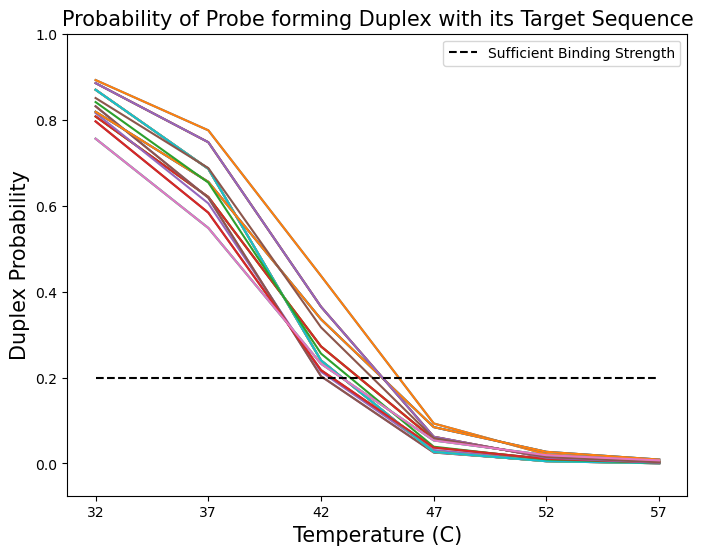

In [12]:
# PLOTTING RESULTS FROM duplex_prob.py #
from duplex_prob import plot_duplex_prob

filtered_filename = 'data/target_seqs/rosa26_against_full/rosa26_probes_filtered.bed'

###################################################################################################

plot_duplex_prob(filtered_filename)

In [59]:
from secondary_structure import filter_secondary_structure

fn = 'data/gui_outputs/rosa26_probes_pDup_filtered.bed'
filter_secondary_structure(fn, 0.0)

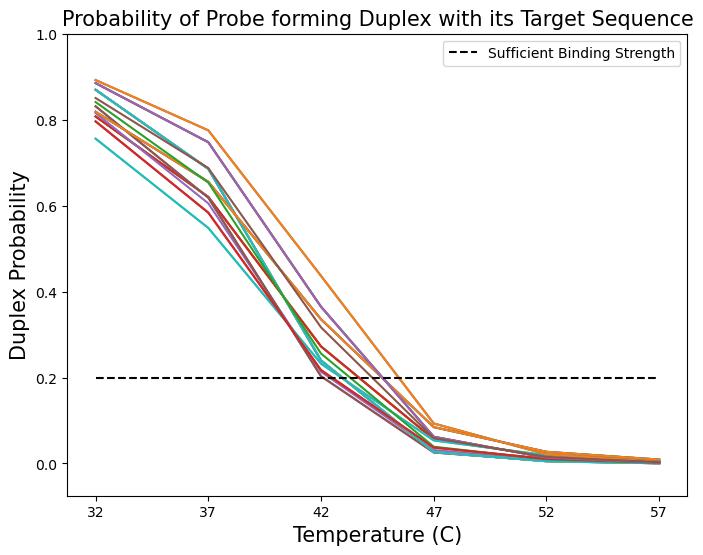

In [1]:
from duplex_prob import filter_duplex_prob, plot_duplex_prob

sam_fn = 'data/gui_outputs/rosa26.sam'
bed_fn = 'data/gui_outputs/rosa26_probes.bed'
filtered_fn = 'data/gui_outputs/rosa26_probes_pDup_filtered.csv'
filter_duplex_prob(sam_fn, bed_fn, filter_temp=42, filter_prob=0.2)
plot_duplex_prob(filtered_fn)